In [1]:
import os
import pandas as pd
from pandas import DataFrame
from keras.models import Sequential, Model, Sequential, load_model
from keras.layers import Dense, Input, Activation, Conv2D, MaxPool2D, Flatten, UpSampling2D, Conv2DTranspose, Reshape, LeakyReLU, Concatenate
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.utils import np_utils, plot_model
from keras import backend as K
import matplotlib.pyplot as plt
# matplotlib.use("TkAgg")
%matplotlib inline
import numpy as np
np.random.seed(1)
from sklearn.metrics import confusion_matrix
from PIL import Image
import random
import math
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import cluster, metrics

Using TensorFlow backend.


In [2]:
if not os.path.exists('model/'):
    os.makedirs('model/')

In [15]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
digit_size = 28
channels = 1
print('x_train\n', X_train.shape)
print('y_train\n', y_train.shape, y_train[0])
print('x_test\n', X_test.shape)
print('y_test\n', y_test.shape)

x_train
 (60000, 28, 28)
y_train
 (60000,) 5
x_test
 (10000, 28, 28)
y_test
 (10000,)


In [16]:
# data pre-processing
X_train = X_train.astype('float32') / 255       # minmax_normalized
X_test = X_test.astype('float32') / 255         # minmax_normalized
X_train = X_train.reshape((-1, digit_size*digit_size*channels))
X_test = X_test.reshape((-1, digit_size*digit_size*channels))
print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


In [17]:
# in order to plot in a 2D figure
encoding_dim = 2

input_x = Input(shape=(digit_size*digit_size*channels,))
x = Dense(512)(input_x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(256)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(64)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
encoded = Dense(encoding_dim, name='encoder_output')(x)

input_ec = Input(shape=(encoding_dim,))
x = Dense(64)(input_ec)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(256)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
decoded = Dense(digit_size*digit_size*channels, activation='tanh', name='decoder_output')(x)

encoder = Model(inputs=input_x, outputs=encoded)
decoder = Model(input_ec, decoded)

# del encoder
# encoder = load_model('model/encoder.h5')
# del decoder
# decoder = load_model('model/decoder.h5')

ec = encoder(input_x)
dc = decoder(ec)
autoencoder = Model(input_x, dc)

autoencoder.compile(loss='mse', optimizer=Adam())

encoder.summary()
decoder.summary()
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               401920    
_________________________________________________________________
batch_normalization_9 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_10 (Batc (None, 256)               1024      
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
__________

In [18]:
# training
autoencoder.fit(X_train, X_train, epochs=10, batch_size=256, shuffle=True)

encoder.save('model/encoder.h5')
decoder.save('model/decoder.h5')

Epoch 1/10
60000/60000 [==============================] - 6s 100us/step - loss: 0.0596
Epoch 2/10
60000/60000 [==============================] - 4s 71us/step - loss: 0.0454
Epoch 3/10
60000/60000 [==============================] - 5s 76us/step - loss: 0.0427
Epoch 4/10
60000/60000 [==============================] - 5s 75us/step - loss: 0.0413
Epoch 5/10
60000/60000 [==============================] - 5s 75us/step - loss: 0.0404
Epoch 6/10
60000/60000 [==============================] - 5s 77us/step - loss: 0.0401
Epoch 7/10
60000/60000 [==============================] - 5s 77us/step - loss: 0.0395
Epoch 8/10
60000/60000 [==============================] - 5s 76us/step - loss: 0.0392
Epoch 9/10
60000/60000 [==============================] - 5s 77us/step - loss: 0.0388
Epoch 10/10
60000/60000 [==============================] - 5s 76us/step - loss: 0.0387


(10, 784)


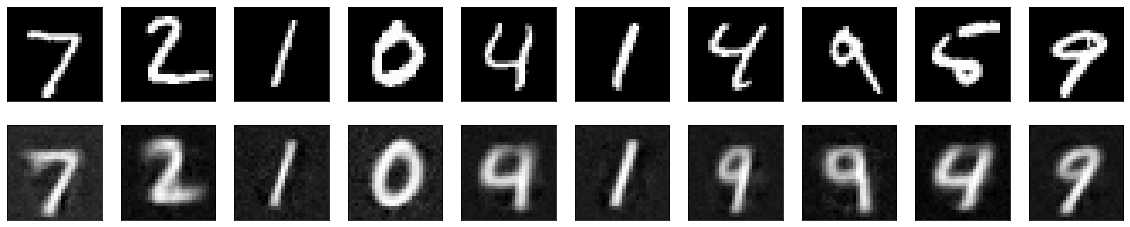

In [19]:
n = 10
decoded_imgs = autoencoder.predict(X_test[:n])
print(decoded_imgs.shape)
  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    if channels > 1:
        plt.imshow(X_test[i].reshape(digit_size, digit_size, channels), cmap='binary')
    else:
        plt.imshow(X_test[i].reshape(digit_size, digit_size))
        plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    if channels > 1:
        plt.imshow(decoded_imgs[i].reshape(digit_size, digit_size, channels), cmap='binary')
    else:
        plt.imshow(decoded_imgs[i].reshape(digit_size, digit_size))
        plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

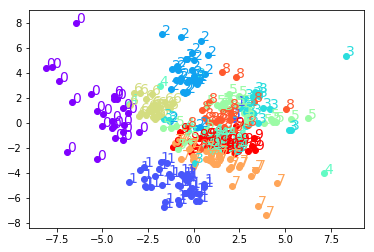

In [20]:
from matplotlib import cm

view_data = X_test[:300]
encoded_data = encoder.predict(view_data)
X, Y = encoded_data[:, 0], encoded_data[:, 1]

for x, y, s in zip(X, Y, y_test):
    c = cm.rainbow(int(255*s/9)); 
    plt.scatter(x, y, c=[c])
    plt.text(x, y, s, fontdict={'size': 14, 'color':c})

plt.show()

(225, 784)


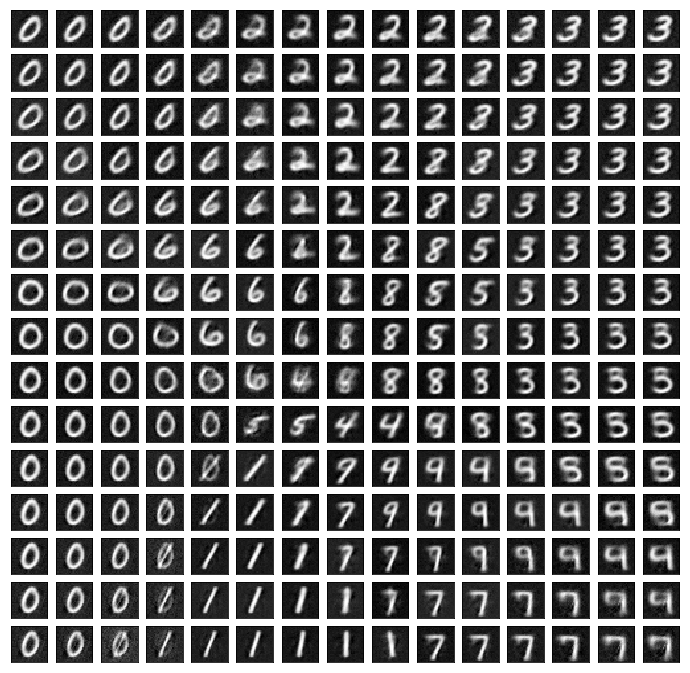

In [22]:
length = 15
x_lins = np.linspace(-6, 5, length, dtype=np.float32)
y_lins = np.linspace(-4, 6, length, dtype=np.float32)
data_draw = np.vstack([np.hstack((x_lins[:,np.newaxis], np.ones([length, 1])*y_lins[length-1-i])) for i in range(length)])
draw_ = decoder.predict(data_draw)
print(draw_.shape)
num = length*length
row = int(math.ceil(num/length))
fig, axes = plt.subplots(row, length, figsize=(length*(12/length), row*(12/length)))
for i, ax in enumerate(axes.flat):
    if channels > 1:
        ax.imshow(np.reshape(draw_[i],[digit_size, digit_size, channels]), cmap='binary')
    else:
        ax.imshow(np.reshape(draw_[i],[digit_size, digit_size]), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

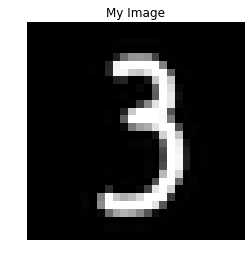

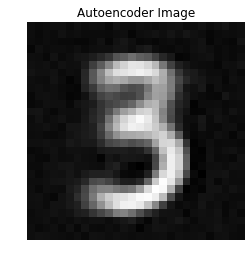

In [23]:
from PIL import Image
im = Image.open("./media/n_3.png")
if channels == 1:
    im = im.convert('L') # 轉成灰階
im = im.resize((digit_size, digit_size), Image.ANTIALIAS) # resize the image
im = np.array(im) #convert to an array
im2 = im.astype('float32') / 255 # normalise input
# 畫圖
plt.imshow(im2, cmap='gray')
plt.title('My Image')
plt.axis('off')
plt.show()

test_image = np.reshape(im2, [1,digit_size*digit_size*channels]) # reshape it to our input placeholder shape
d_ = autoencoder.predict(test_image)
# 畫圖
if channels > 1:
    plt.imshow(np.reshape(d_, (digit_size, digit_size, channels)), cmap='binary')
else:
    plt.imshow(np.reshape(d_, (digit_size, digit_size)), cmap='gray')
plt.title('Autoencoder Image')
plt.axis('off')
plt.show()